# Mask R-CNN - Train on Astro Objects


Based on example of training Mask R-CNN on Shapes dataset.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11163908721725881440, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17612016139053028682
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10272909989163863408
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15596303156
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12432672996676701983
 physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:58:00.0, compute capability: 7.0"]

## Configurations

In [3]:
class AstroObjectsConfig(Config):
    """Configuration for training on the astroobjects dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "astroobjects"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 object

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 61
    
config = AstroObjectsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [5]:
from astropy.io import fits
from astropy.visualization.lupton_rgb import make_lupton_rgb
from matplotlib.image import imsave
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import random

def crops(fnames, xrange, yrange):
    return [fits.open(f)[0].data[xrange[0]:xrange[1], yrange[0]:yrange[1]] for f in fnames]

class AstroObjectDataset(utils.Dataset):

    def load_hst_images(self, cropsize=256, datadir='../../../data/', start=None, stop=None):
        # Add classes
        self.add_class("astroobject", 1, "object")
        self.nclass = 1

        # Add images
        images = glob(datadir+'HST/crops/crop*npy')
        random.seed(12345)
        random.shuffle(images)
        print('Total number of images:', len(images))
        with open(datadir+'HST/sex/t1_1.sex.outparam') as f:
            param = [x.strip() for x in f.readlines()]
        self.datatable = pd.read_csv(datadir+'HST/sex/t1_1.sex.outcat', sep=' ',
                                     header=None, names=param).set_index('NUMBER')
        if start is None:
            start = 0
        if stop is None:
            stop = len(images)
        count = 0
        for k in range(start, stop):
            count += 1
            self.add_image("astroobject", image_id=k, path=images[k],
                           width=cropsize, height=cropsize)
        print('Number of images used:', count)
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = np.load(info['path'])
        return img

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        seg = np.load(info['path'].replace('/crop_', '/mask_'))
        segids = list(set(seg.ravel()) - set([0]))
        nobj = len(segids)
        mask = np.zeros(seg.shape + (nobj,), np.bool)
        class_ids = np.zeros(nobj, dtype=np.int32)
        for i in range(nobj):
            mask[:,:,i] = seg == segids[i]
            class_ids[i] = 1
        return mask, class_ids

In [6]:
# Training dataset
dataset_train = AstroObjectDataset()
dataset_train.load_hst_images(stop=300)
dataset_train.prepare()

# Validation dataset
dataset_val = AstroObjectDataset()
dataset_val.load_hst_images(start=300)
dataset_val.prepare()

Total number of images: 361
Number of images used: 300
Total number of images: 361
Number of images used: 61


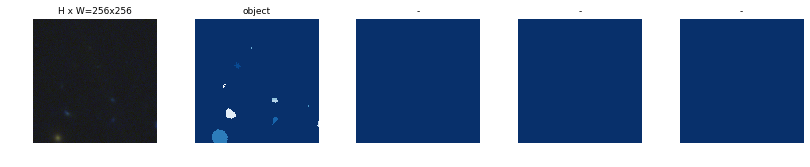

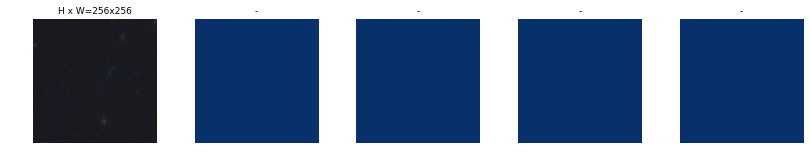

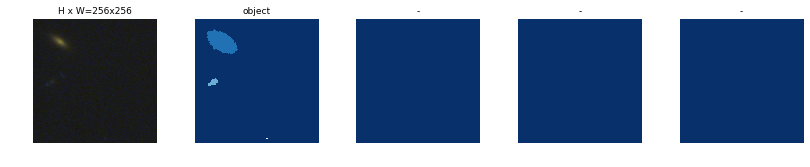

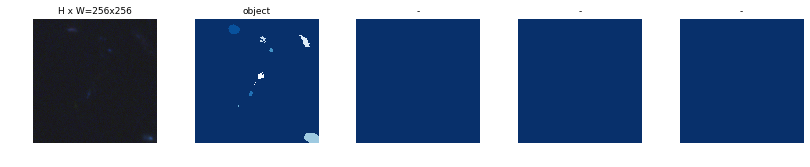

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [22]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [23]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 50


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190402T0009/mask_rcnn_astroobjects_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

300/300 [==============================] - 79s 265ms/step - loss: 1.3050 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.4697 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3447 - val_loss: 2.7274 - val_rpn_class_loss: 0.1482 - val_rpn_bbox_loss: 1.3569 - val_mrcnn_class_loss: 0.2457 - val_mrcnn_bbox_loss: 0.5237 - val_mrcnn_mask_loss: 0.4529
Epoch 20/50
300/300 [==============================] - 82s 273ms/step - loss: 1.1200 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.3577 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3267 - val_loss: 2.7787 - val_rpn_class_loss: 0.1388 - val_rpn_bbox_loss: 1.3619 - val_mrcnn_class_loss: 0.3096 - val_mrcnn_bbox_loss: 0.4929 - val_mrcnn_mask_loss: 0.4755
Epoch 21/50
300/300 [==============================] - 83s 276ms/step - loss: 1.0668 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.3373 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.3302 - val_loss: 2.7903 - val_rpn_class_loss

Epoch 41/50
300/300 [==============================] - 80s 267ms/step - loss: 0.9987 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.3391 - val_loss: 3.4719 - val_rpn_class_loss: 0.1924 - val_rpn_bbox_loss: 1.9078 - val_mrcnn_class_loss: 0.3750 - val_mrcnn_bbox_loss: 0.4687 - val_mrcnn_mask_loss: 0.5280
Epoch 42/50
300/300 [==============================] - 80s 268ms/step - loss: 0.7094 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2772 - val_loss: 3.2178 - val_rpn_class_loss: 0.1501 - val_rpn_bbox_loss: 1.3917 - val_mrcnn_class_loss: 0.3543 - val_mrcnn_bbox_loss: 0.6066 - val_mrcnn_mask_loss: 0.7150
Epoch 43/50
300/300 [==============================] - 79s 263ms/step - loss: 0.6935 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2695 - val_loss: 3.8401 - val_rp

In [24]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=75, 
            layers="all")


Starting at epoch 50. LR=0.0001

Checkpoint Path: /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190402T0009/mask_rcnn_astroobjects_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

/gpfs01/home/ppzsb1/.conda/envs/astobjdet/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/gpfs01/home/ppzsb1/.conda/envs/astobjdet/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/75
300/300 [==============================] - 164s 548ms/step - loss: 0.9334 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.3253 - val_loss: 4.1280 - val_rpn_class_loss: 0.2976 - val_rpn_bbox_loss: 2.0633 - val_mrcnn_class_loss: 0.5349 - val_mrcnn_bbox_loss: 0.5543 - val_mrcnn_mask_loss: 0.6779
Epoch 52/75
300/300 [==============================] - 125s 417ms/step - loss: 0.9870 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.2895 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.3198 - val_loss: 3.2299 - val_rpn_class_loss: 0.1689 - val_rpn_bbox_loss: 1.6369 - val_mrcnn_class_loss: 0.3316 - val_mrcnn_bbox_loss: 0.5061 - val_mrcnn_mask_loss: 0.5864
Epoch 53/75
300/300 [==============================] - 124s 413ms/step - loss: 0.8845 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.3285 - val_loss: 3.4613 - val

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



300/300 [==============================] - 126s 421ms/step - loss: 0.5988 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.2676 - val_loss: 3.1767 - val_rpn_class_loss: 0.1290 - val_rpn_bbox_loss: 1.4408 - val_mrcnn_class_loss: 0.4389 - val_mrcnn_bbox_loss: 0.5325 - val_mrcnn_mask_loss: 0.6354
Epoch 68/75
300/300 [==============================] - 127s 424ms/step - loss: 0.5654 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.2645 - val_loss: 3.3767 - val_rpn_class_loss: 0.1252 - val_rpn_bbox_loss: 1.5451 - val_mrcnn_class_loss: 0.4595 - val_mrcnn_bbox_loss: 0.5678 - val_mrcnn_mask_loss: 0.6791
Epoch 69/75
300/300 [==============================] - 127s 423ms/step - loss: 0.5596 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.2675 - val_loss: 3.3482 - val_rpn_class_l

In [25]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [26]:
class InferenceConfig(AstroObjectsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /gpfs01/home/ppzsb1/astobjdet/Mask_RCNN/logs/astroobjects20190402T0009/mask_rcnn_astroobjects_0075.h5
Re-starting from epoch 75


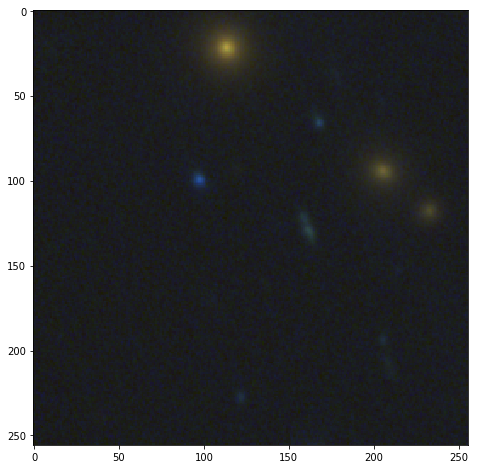

In [52]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

plt.figure(figsize=(8, 8))
plt.imshow(original_image)

original_image           shape: (256, 256, 3)         min:    0.00000  max:  181.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 14)        min:    0.00000  max:    1.00000  bool


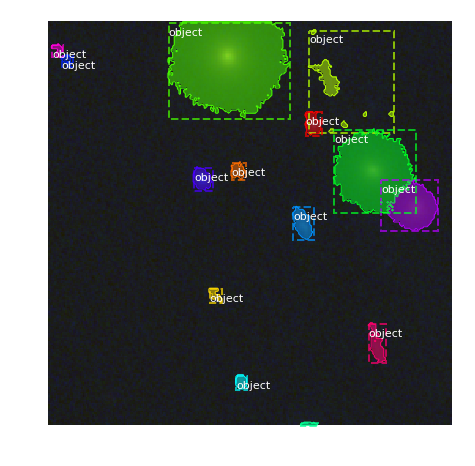

In [53]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  181.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.90000  max:   57.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


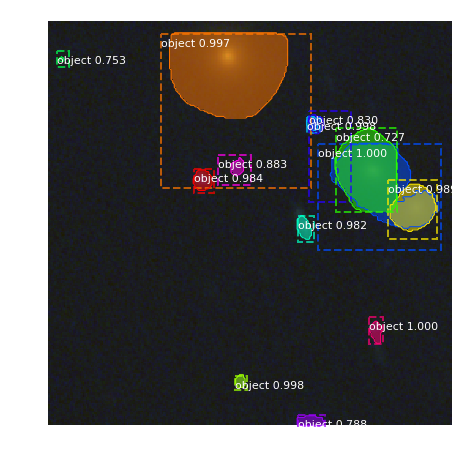

In [54]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [29]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.25965084319982007
